In [1]:
import torch
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

def hist_and_box(data_in, bins=50, title=None, save_filename=None):
  data = data_in.detach().cpu()
  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  # Plot a histogram of the data
  n, bins, patches = ax1.hist(data, bins=bins)
  ax1.set_xlabel('Value')
  ax1.set_ylabel('Frequency')
  ax1.set_title('Histogram')

  # Plot a boxplot of the data
  ax2.boxplot(data)
  ax2.set_xticklabels(['Data'])
  ax2.set_ylabel('Value')
  ax2.set_title('Boxplot')

  if title is not None:
    plt.suptitle(title)

  if save_filename is not None:
    plt.savefig(save_filename)

  # Show the plot
  plt.show()
  plt.close(fig)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def get_similarities(d, n):
  a = torch.randn(1, d).to(device)
  a = F.normalize(a, dim=1)

  x = torch.randn(n, d).to(device)
  x = F.normalize(x, dim=1)

  dots = torch.einsum('nd,md->nm',x,a).reshape(-1)
  assert len(dots) == n
  return dots

In [ ]:
ds = torch.arange(10, 10000, 100) #[10, 100, 512, 768, 2 ** 10, 2 ** 11, 2 ** 12, 2 ** 13]
dots_list = torch.stack([get_similarities(d,n) for d in ds])

In [ ]:
epses = torch.max(dots_list, dim=-1).values

In [ ]:
epses[9]

tensor(0.1405)

Text(0.5, 1.0, 'Maximum similarity out of 10K random vectors')

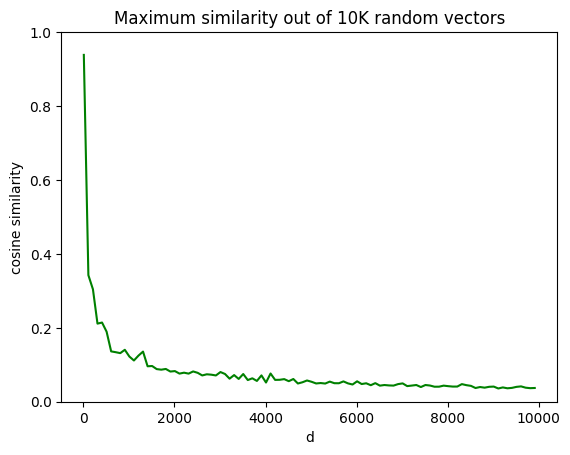

In [ ]:
plt.plot(ds, epses, color='green')
plt.ylim((0,1))
plt.xlabel('d')
plt.ylabel('cosine similarity')
plt.title('Maximum similarity out of 10K random vectors')

# Variance in eps(d) approximations

In [ ]:
get_similarities(1024,500000).max()

tensor(0.1505)

In [ ]:
eps1024s = []
for i in tqdm(range(1000)):
  eps1024s.append(get_similarities(1024,n).max())

100%|██████████| 1000/1000 [02:22<00:00,  7.02it/s]


In [ ]:
max(eps1024s)

tensor(0.1670)

In [ ]:
eps1024 = torch.tensor(eps1024s).mean()

Text(0.5, 1.0, 'Epsilon for d = 1024 over 1K iterations with N = 10K')

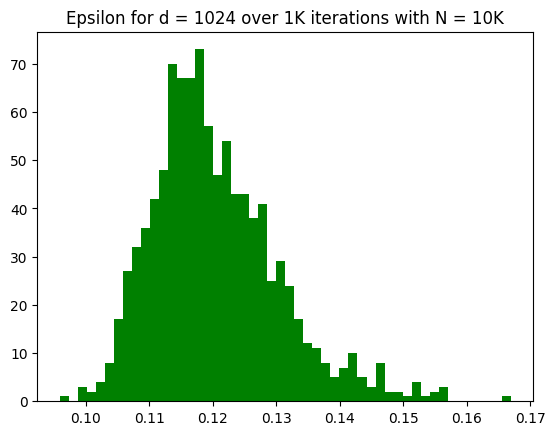

In [ ]:
plt.hist(eps1024s,bins=50, color='green')
plt.title('Epsilon for d = 1024 over 1K iterations with N = 10K')

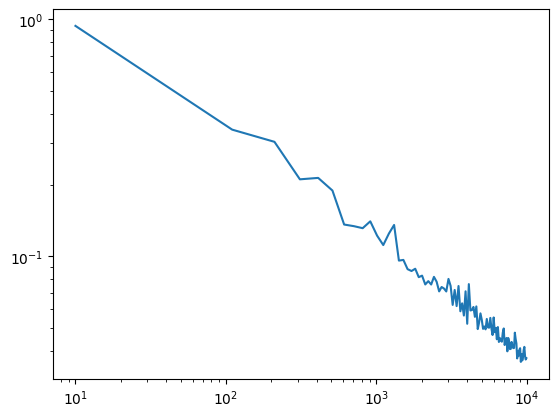

In [ ]:
plt.loglog(ds, torch.max(dots_list, dim=-1).values)

10


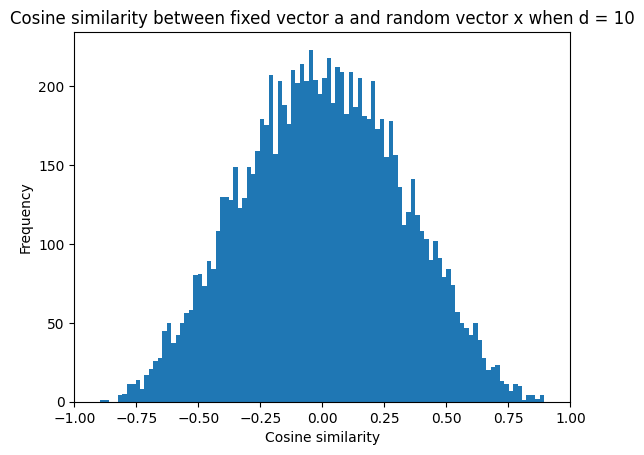

100


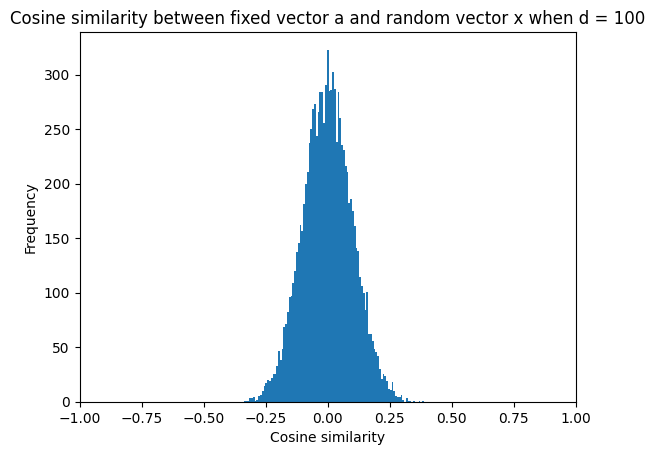

512


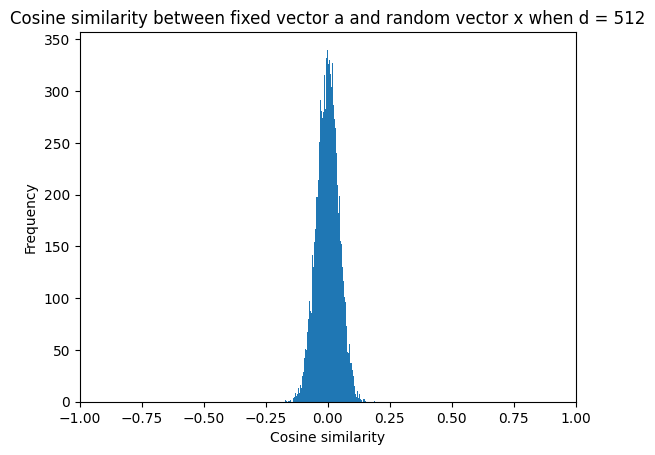

768


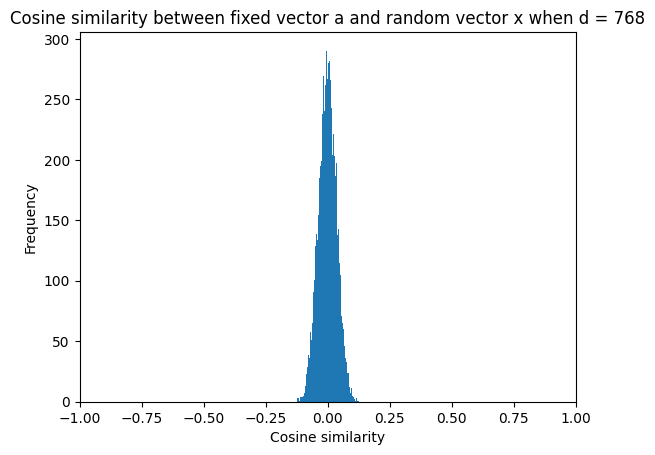

1024


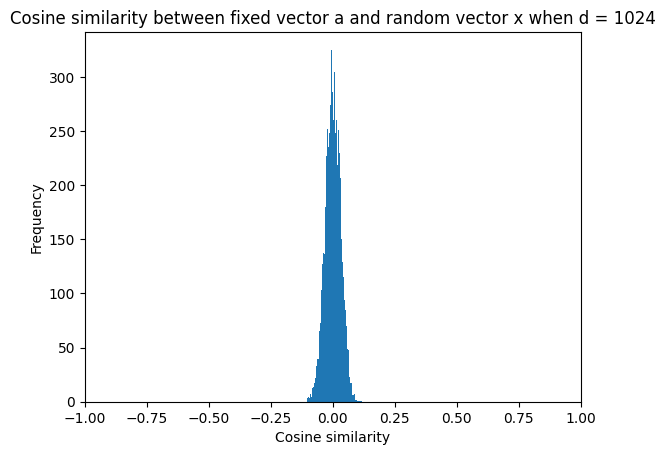

2048


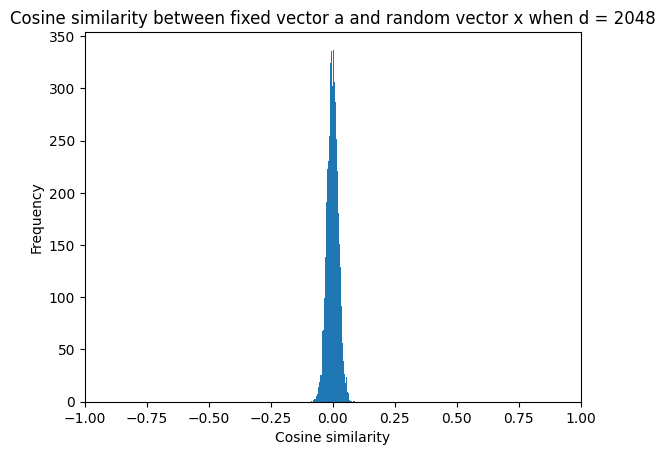

4096


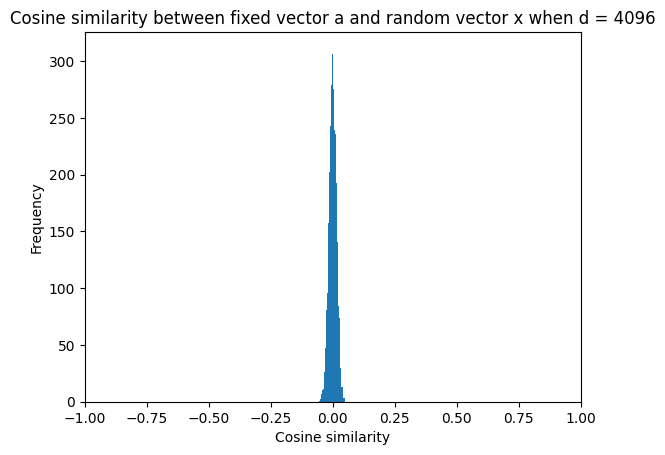

8192


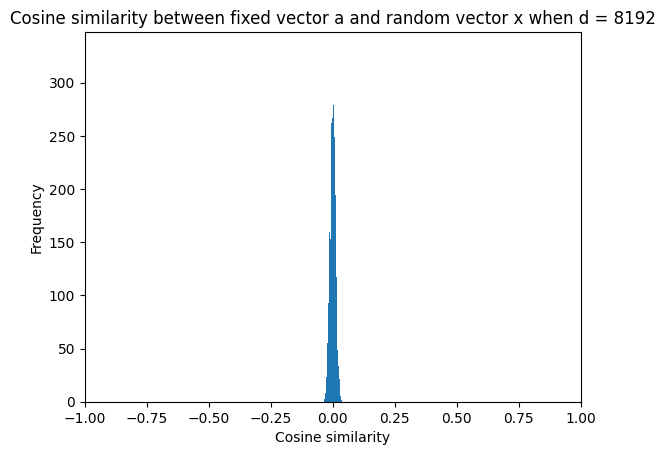

In [ ]:
for d, dots in zip(ds, dots_list):
  print(d)
  plt.hist(dots.cpu(),bins=100)
  plt.xlim(-1,1)
  plt.xlabel('Cosine similarity')
  plt.ylabel('Frequency')
  plt.title(f'Cosine similarity between fixed vector a and random vector x when d = {d}')
  plt.show()

In [ ]:
for d, dots in zip(ds, dots_list):
  print('d:', d)
  print(f'Fraction epsilon close to orthogonal: {(torch.abs(dots) < eps).float().mean():.6}')
  print(f'Fraction at least epsilon similar: {(dots > eps).float().mean().item():.6}')

d: 10
Fraction epsilon close to orthogonal: 0.0249
Fraction at least epsilon similar: 0.4867
d: 100
Fraction epsilon close to orthogonal: 0.0753
Fraction at least epsilon similar: 0.4676
d: 512
Fraction epsilon close to orthogonal: 0.1777
Fraction at least epsilon similar: 0.4149
d: 768
Fraction epsilon close to orthogonal: 0.2217
Fraction at least epsilon similar: 0.3897
d: 1024
Fraction epsilon close to orthogonal: 0.2536
Fraction at least epsilon similar: 0.3828
d: 2048
Fraction epsilon close to orthogonal: 0.3455
Fraction at least epsilon similar: 0.3276
d: 4096
Fraction epsilon close to orthogonal: 0.4778
Fraction at least epsilon similar: 0.2572
d: 8192
Fraction epsilon close to orthogonal: 0.6414
Fraction at least epsilon similar: 0.1808


# Capacity

In [ ]:
n = 30000
d = 1024
x = torch.randn(n, d).to(device)
x = F.normalize(x, dim=1)

In [ ]:
from tqdm import tqdm

In [ ]:
def get_similarity_matrix(A):
  norms = torch.norm(A, dim=1)
  dot_products = A @ A.t()
  B = dot_products / torch.ger(norms, norms)
  return B


In [ ]:
max_sims = []
for i in tqdm(range(10,5000,100)):
  max_sim_candidates = torch.zeros(10)
  for k in range(1):
    n = i
    d = 1024
    x = torch.randn(n, d).to(device)
    x = F.normalize(x, dim=1)
    x_sim = get_similarity_matrix(x)
    max_sim_candidates[k] = torch.triu(x_sim,diagonal=1).max()
  max_sims.append(max_sim_candidates.mean())

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


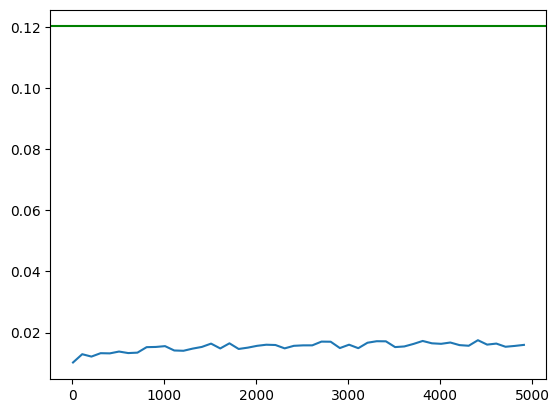

In [ ]:
plt.plot(torch.arange(10,10000,100)[:len(max_sims)],max_sims)
plt.axhline(y=eps1024, color='green')

In [ ]:
plt.plot(torch.arange(10,10000,100),max_sims)

100

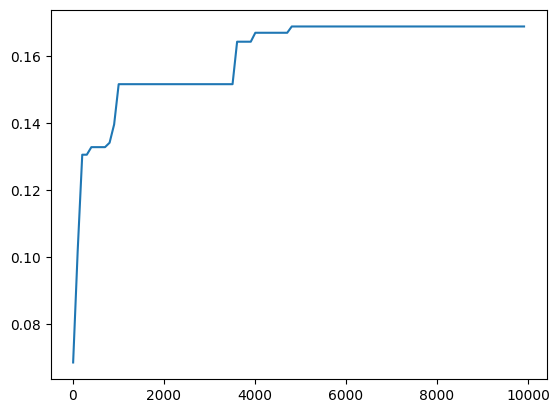

In [ ]:
plt.plot(torch.arange(10,10000,100),max_sims)

# Empirical capacity

In [ ]:
def get_similarity_cross(A1, A2):
    norms_A1 = torch.norm(A1, dim=1)
    norms_A2 = torch.norm(A2, dim=1)

    dot_products = A1 @ A2.t()

    B = dot_products / torch.ger(norms_A1, norms_A2)

    return B

In [ ]:
random_dset_cpu = torch.load('/content/drive/MyDrive/thesis/derived_data/similarity_replication/10k_random_occs_410m_all_residual_cpu.pt')

In [ ]:
for hook_name, X in random_dset_cpu.items():
  print(hook_name, X.shape)

blocks.0.hook_resid_post torch.Size([2000, 1024])
blocks.1.hook_resid_post torch.Size([2000, 1024])
blocks.2.hook_resid_post torch.Size([2000, 1024])
blocks.3.hook_resid_post torch.Size([2000, 1024])
blocks.4.hook_resid_post torch.Size([2000, 1024])
blocks.5.hook_resid_post torch.Size([2000, 1024])
blocks.6.hook_resid_post torch.Size([2000, 1024])
blocks.7.hook_resid_post torch.Size([2000, 1024])
blocks.8.hook_resid_post torch.Size([2000, 1024])
blocks.9.hook_resid_post torch.Size([2000, 1024])
blocks.10.hook_resid_post torch.Size([2000, 1024])
blocks.11.hook_resid_post torch.Size([2000, 1024])
blocks.12.hook_resid_post torch.Size([2000, 1024])
blocks.13.hook_resid_post torch.Size([2000, 1024])
blocks.14.hook_resid_post torch.Size([2000, 1024])
blocks.15.hook_resid_post torch.Size([2000, 1024])
blocks.16.hook_resid_post torch.Size([2000, 1024])
blocks.17.hook_resid_post torch.Size([2000, 1024])
blocks.18.hook_resid_post torch.Size([2000, 1024])
blocks.19.hook_resid_post torch.Size([200

In [ ]:
X = random_dset_cpu['blocks.2.hook_resid_post']

In [ ]:
def z_standardize(tensor):
    # Compute mean and standard deviation along each feature dimension
    mean = torch.mean(tensor, dim=0, keepdim=True)
    std = torch.std(tensor, dim=0, keepdim=True)
    # Perform Z-score standardization
    z_standardized_tensor = (tensor - mean) / (std + 1e-7)  # Adding a small value to avoid division by zero
    return z_standardized_tensor

In [ ]:
Xz = z_standardize(X)

In [ ]:
X.shape

torch.Size([2000, 1024])

In [ ]:
A = torch.randn(2000, 1024)

In [ ]:
XA_sim = get_similarity_cross(X,A)

In [ ]:
XzA_sim = get_similarity_cross(Xz,A)

In [ ]:
X_sim = get_similarity_cross(X,X)

In [ ]:
Xz_sim = get_similarity_cross(Xz,Xz)

In [ ]:
torch.triu(X_sim,diagonal=1).max()

tensor(0.9991)

In [ ]:
A_sim = get_similarity_cross(A,A)

In [ ]:
torch.triu(A_sim,diagonal=1).max()

tensor(0.1571)

In [ ]:
XA_sim.shape

torch.Size([2000, 2000])

In [ ]:
XA_sim.max()

tensor(0.1456)

In [ ]:
XzA_sim.max()

tensor(0.1529)

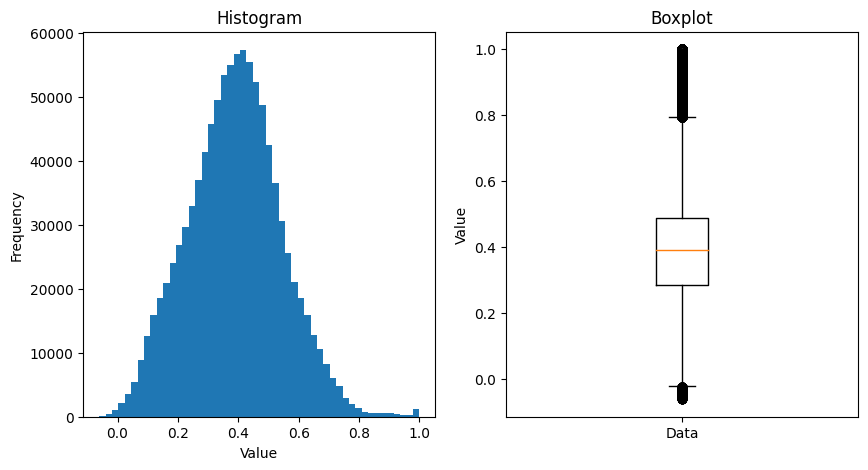

In [ ]:
hist_and_box(X_sim[:1000,:1000].reshape(-1))

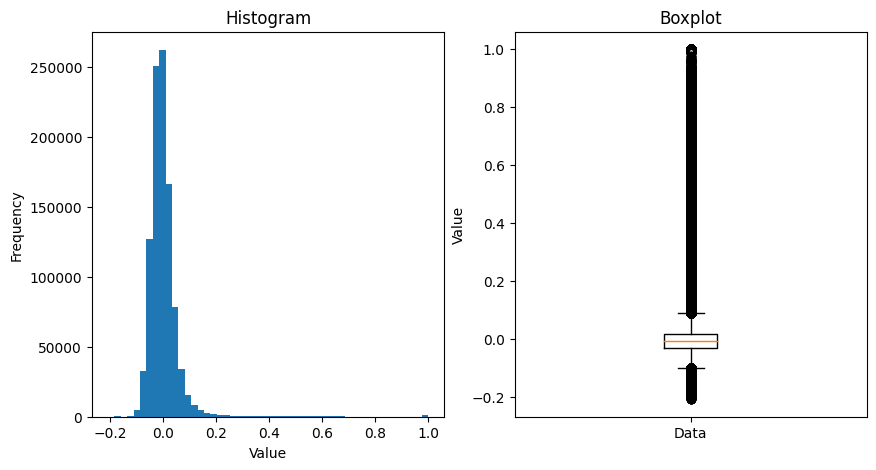

In [ ]:
hist_and_box(Xz_sim[:1000,:1000].reshape(-1))

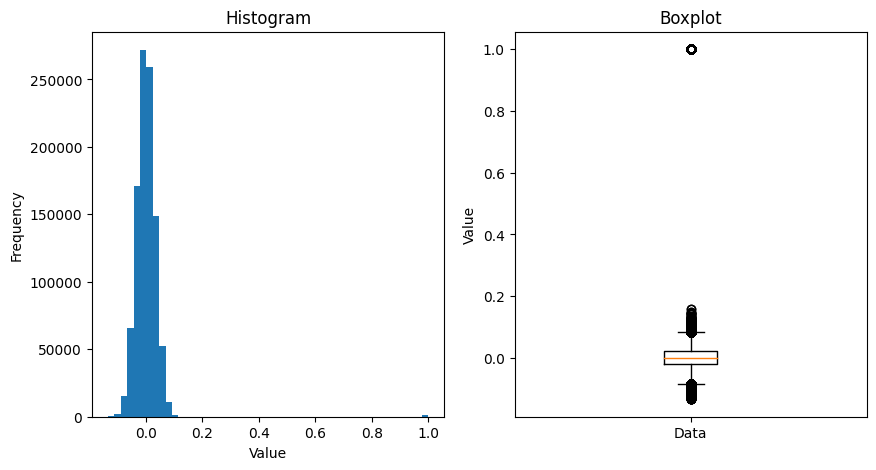

In [ ]:
hist_and_box(A_sim[:1000,:1000].reshape(-1))

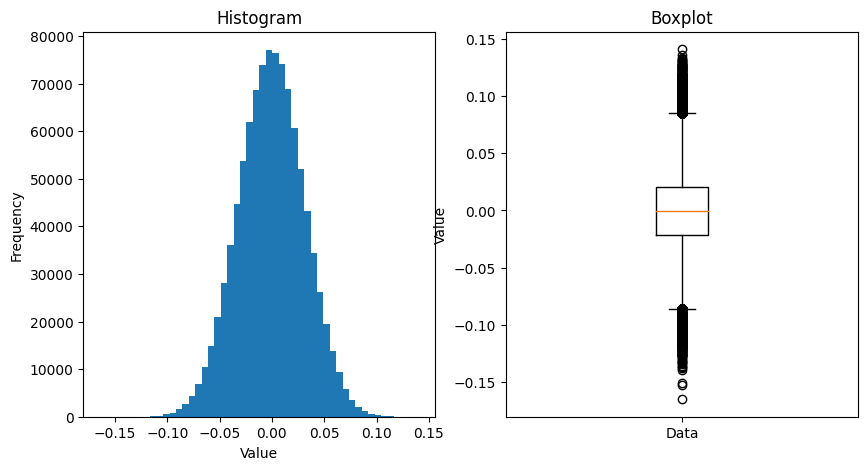

In [ ]:
hist_and_box(XA_sim[:1000,:1000].reshape(-1))

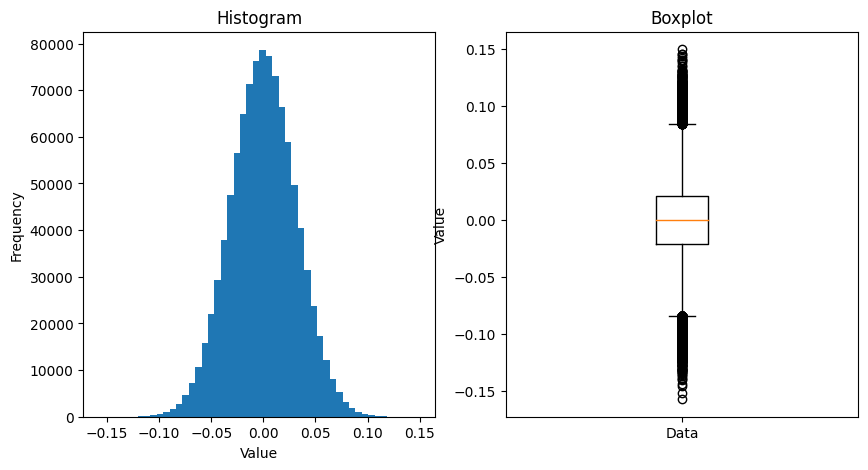

In [ ]:
hist_and_box(XzA_sim[:1000,:1000].reshape(-1))

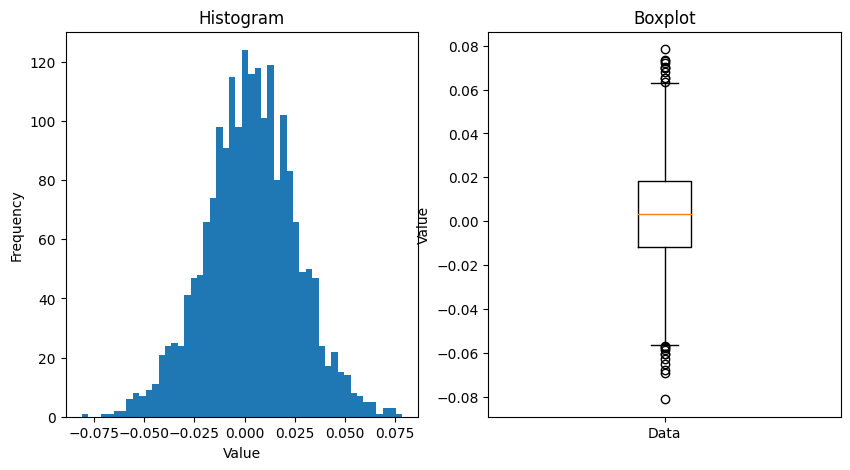

In [ ]:
hist_and_box(XA_sim[:,0])

# HDC addivitity

In [ ]:
A.shape

torch.Size([2000, 1024])

In [ ]:
def disp(x):
  return round(x.item(),2)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def upper_quantile(tensor, q=0.95):
    if q < 0 or q > 1:
        raise ValueError("q must be between 0 and 1.")
    # Sort the tensor
    sorted_tensor, _ = torch.sort(tensor)
    # Find index for the qth quantile
    index_q = int(q * len(sorted_tensor))
    # Retrieve the value at the qth quantile
    value_q = sorted_tensor[index_q]
    return value_q.item()

In [ ]:
def get_df(n,d,k_max):
  A = torch.randn(n, d)
  ks = torch.arange(1,k_max)
  entries = []
  for k in tqdm(ks):
    alpha = torch.zeros(n)
    alpha[:k] = 1
    s = torch.einsum('nd,n->d', A, alpha)
    s_sims = get_similarity_cross(A, s.reshape(1,-1)).reshape(-1)
    first_sims = s_sims[:k]
    rest_sims = s_sims[k:]

    entry = {
        'k': k.item(),
        'first_mean': first_sims.mean().item(),
        'first_median': first_sims.median().item(),
        'first_min': first_sims.min().item(),
        'first_max': first_sims.max().item(),
        'first_q05': upper_quantile(first_sims,q=0.05),
        'rest_mean': rest_sims.mean().item(),
        'rest_median': rest_sims.median().item(),
        'rest_min': rest_sims.min().item(),
        'rest_max': rest_sims.max().item(),
        'rest_q95': upper_quantile(rest_sims),
    }
    entries.append(entry)
  df = pd.DataFrame(entries)
  return df

In [ ]:
def plot_df(df):
  plt.plot(df['k'], df['first_min'], label='first mins')
  plt.plot(df['k'], df['rest_max'], label='rest max')
  plt.plot(df['k'], df['rest_median'], label='rest median')
  plt.plot(df['k'], df['first_median'], label='first medians')
  plt.plot(df['k'], df['first_max'], label='first maxs')
  plt.plot(df['k'], df['rest_q95'], label='rest_q95')
  plt.plot(df['k'], df['first_q05'], label='first_q05')
  plt.legend()
  plt.xlabel('Combination size')
  plt.ylabel('Cosine similarity')
  plt.show()

d 100


100%|██████████| 499/499 [00:00<00:00, 607.83it/s]


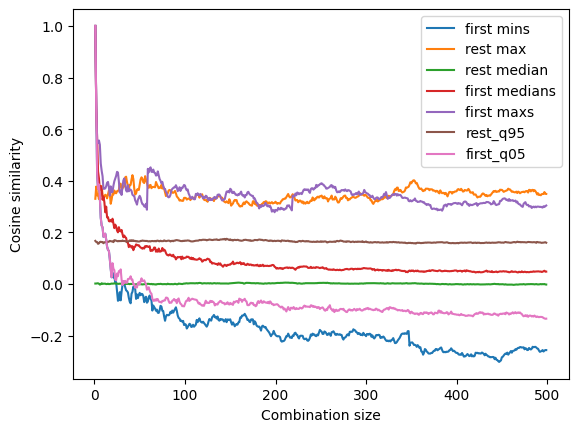

cross k 5
d 600


100%|██████████| 499/499 [00:01<00:00, 253.93it/s]


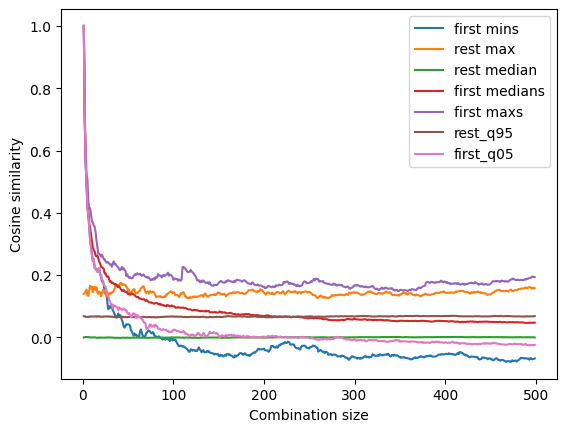

cross k 23
d 1100


100%|██████████| 499/499 [00:02<00:00, 178.57it/s]


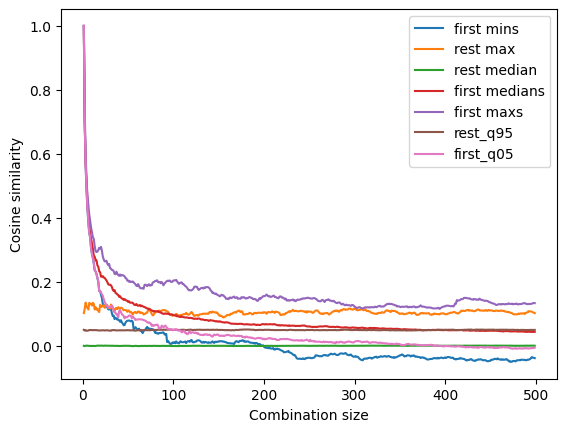

cross k 24
d 1600


100%|██████████| 499/499 [00:03<00:00, 134.80it/s]


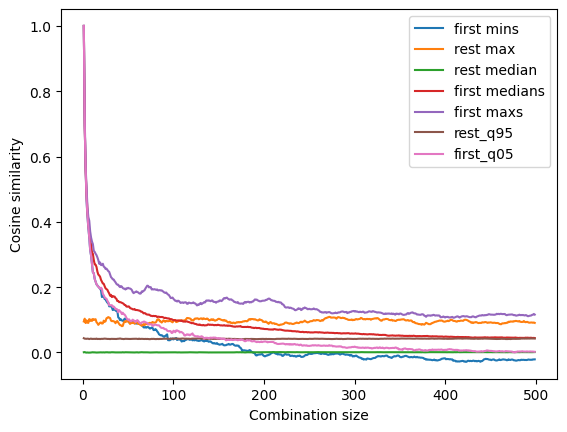

cross k 49
d 2100


100%|██████████| 499/499 [00:05<00:00, 93.22it/s]


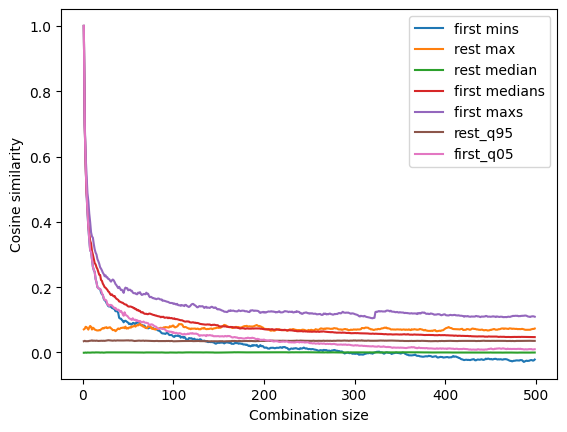

cross k 64
d 2600


100%|██████████| 499/499 [00:06<00:00, 73.73it/s]


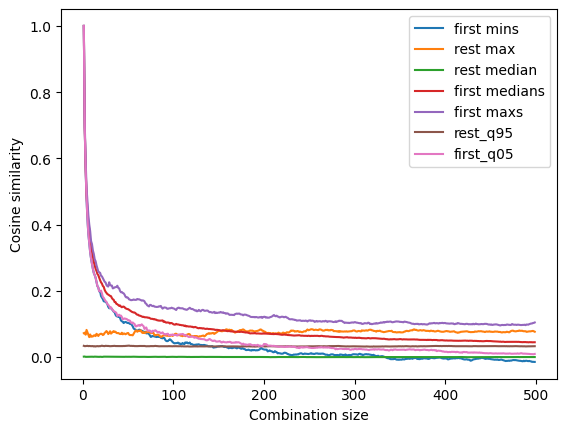

cross k 58
d 3100


100%|██████████| 499/499 [00:07<00:00, 63.95it/s]


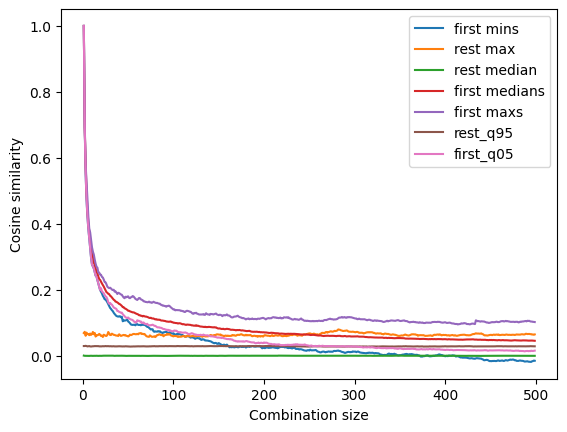

cross k 114
d 3600


100%|██████████| 499/499 [00:08<00:00, 55.75it/s]


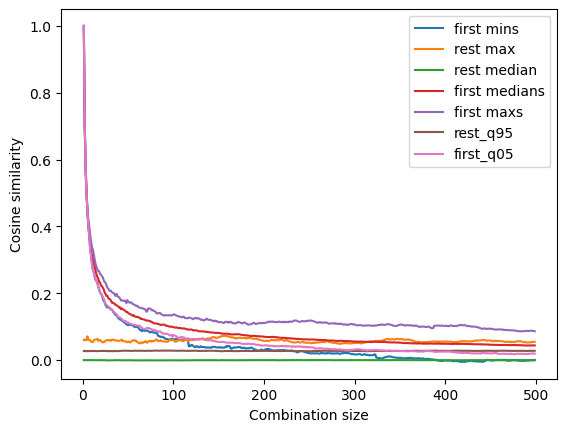

cross k 106
d 4100


100%|██████████| 499/499 [00:11<00:00, 44.28it/s]


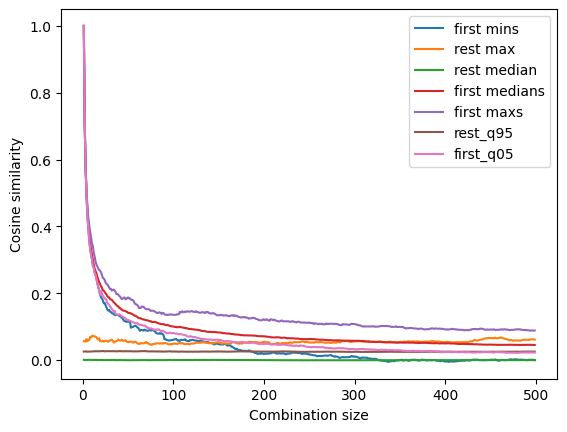

cross k 141
d 4600


100%|██████████| 499/499 [00:10<00:00, 45.40it/s]


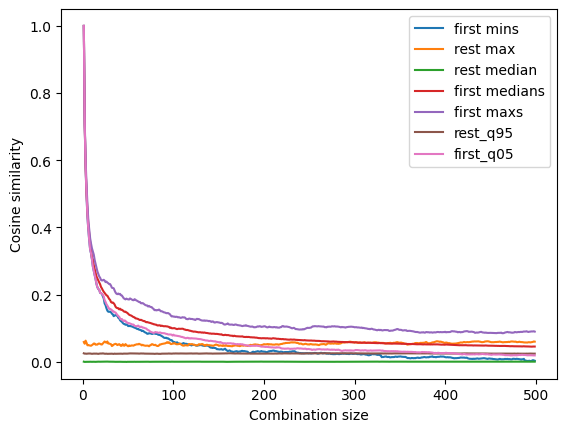

cross k 106
d 5100


100%|██████████| 499/499 [00:14<00:00, 33.64it/s]


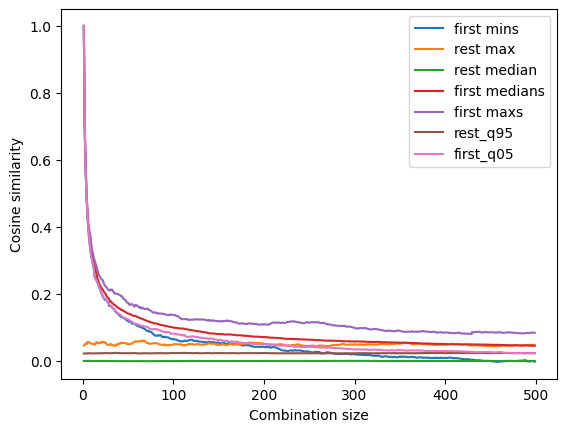

cross k 169
d 5600


100%|██████████| 499/499 [00:13<00:00, 38.01it/s]


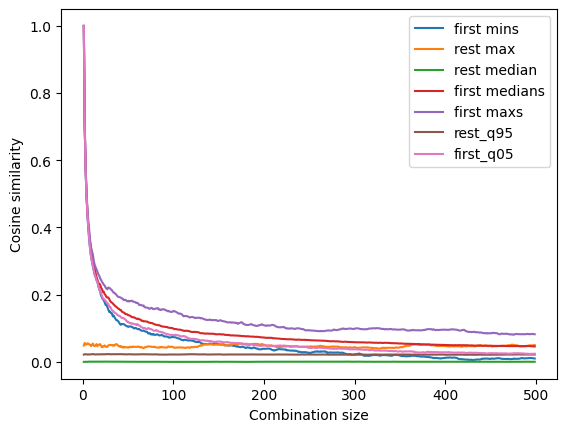

cross k 150
d 6100


100%|██████████| 499/499 [00:14<00:00, 34.69it/s]


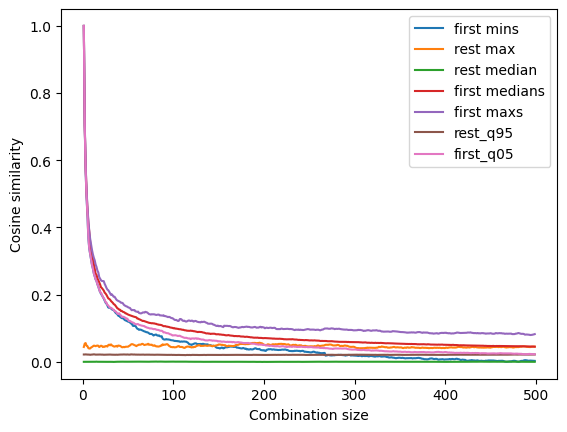

cross k 144
d 6600


100%|██████████| 499/499 [00:15<00:00, 32.74it/s]


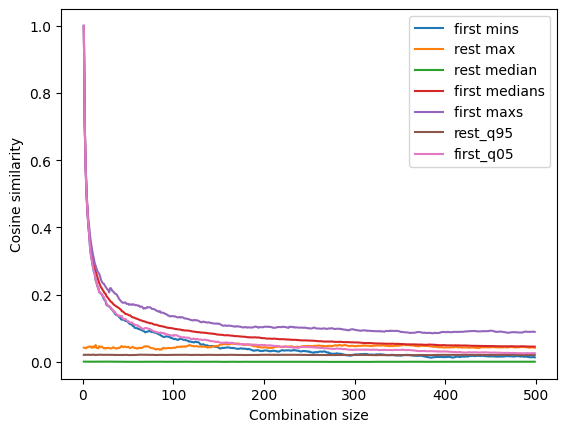

cross k 145
d 7100


100%|██████████| 499/499 [00:16<00:00, 30.19it/s]


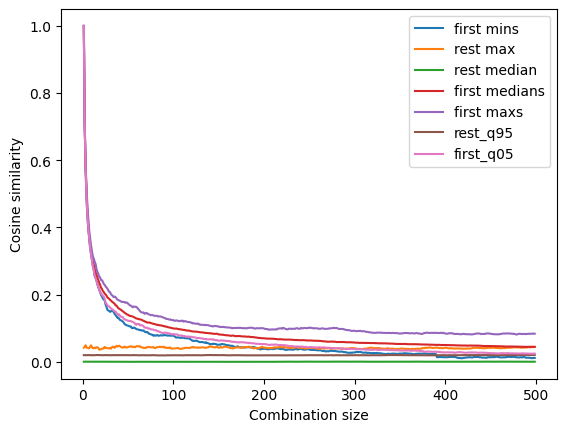

cross k 174
d 7600


100%|██████████| 499/499 [00:26<00:00, 18.64it/s]


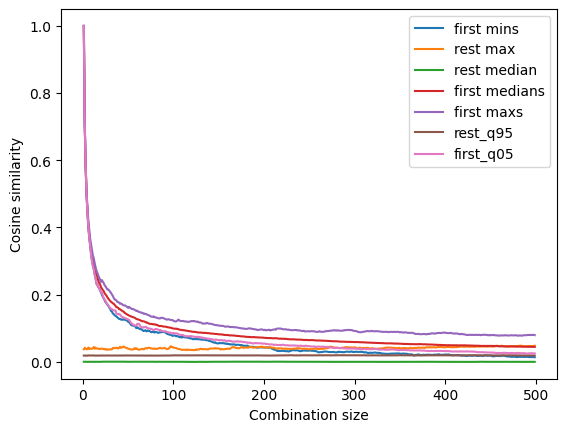

cross k 191
d 8100


100%|██████████| 499/499 [00:24<00:00, 19.97it/s]


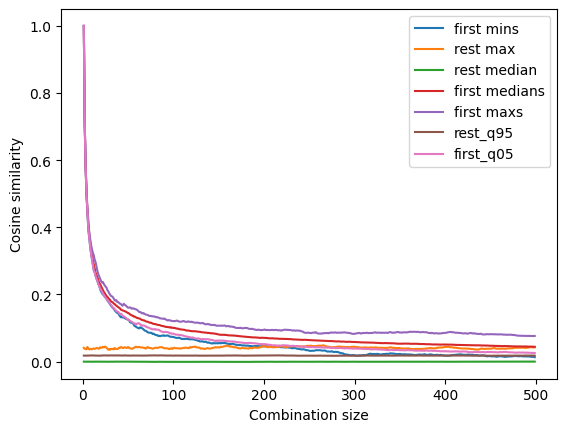

cross k 198
d 8600


100%|██████████| 499/499 [00:23<00:00, 20.92it/s]


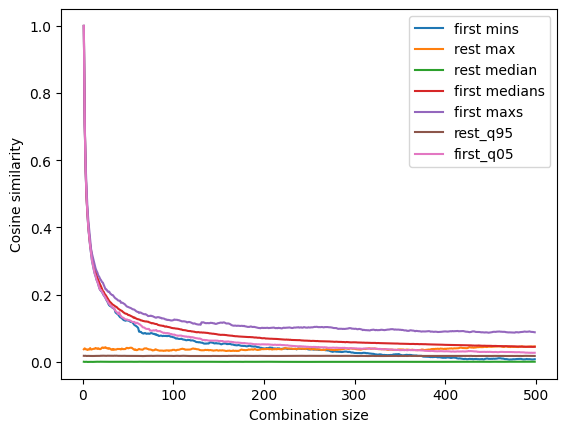

cross k 217
d 9100


100%|██████████| 499/499 [00:28<00:00, 17.65it/s]


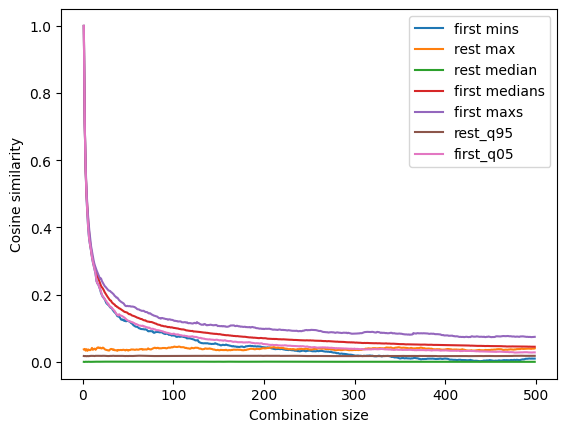

cross k 206
d 9600


100%|██████████| 499/499 [00:22<00:00, 22.60it/s]


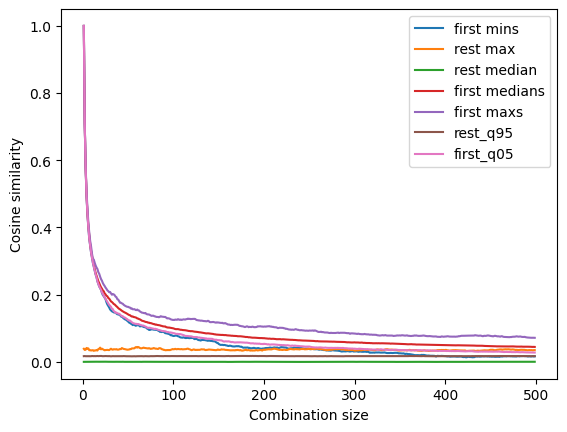

cross k 249
d 10100


100%|██████████| 499/499 [00:22<00:00, 21.88it/s]


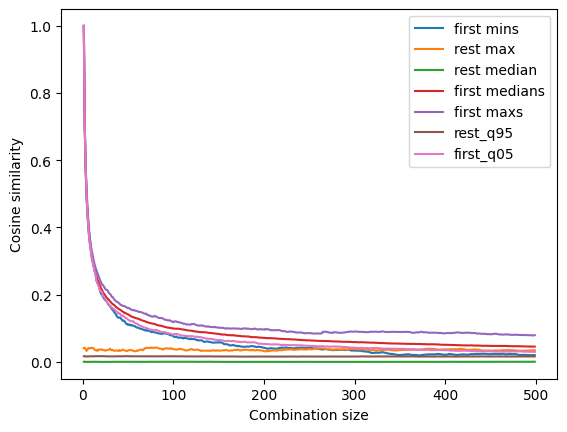

cross k 259
d 10600


100%|██████████| 499/499 [00:24<00:00, 20.60it/s]


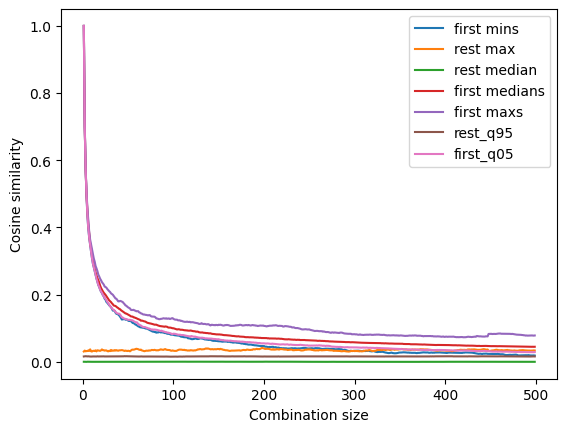

cross k 296
d 11100


100%|██████████| 499/499 [00:26<00:00, 19.03it/s]


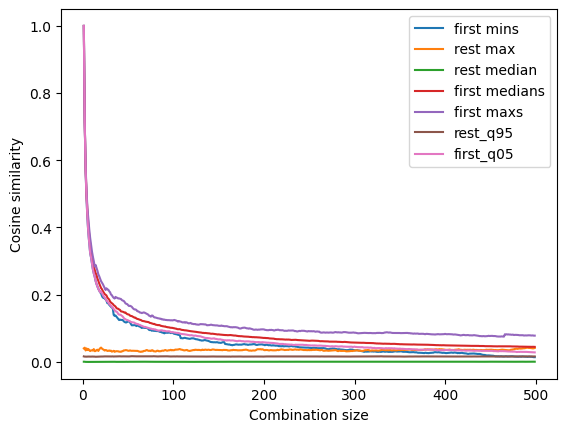

cross k 305
d 11600


100%|██████████| 499/499 [00:26<00:00, 19.00it/s]


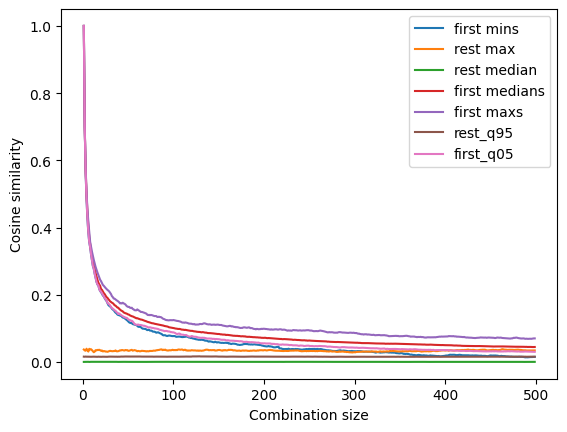

cross k 308
d 12100


100%|██████████| 499/499 [00:27<00:00, 18.13it/s]


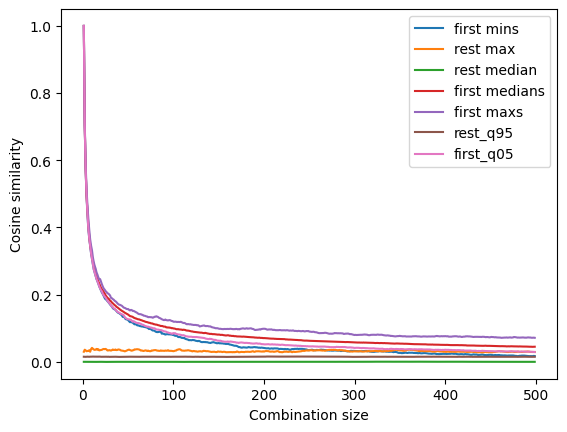

cross k 255
d 12600


100%|██████████| 499/499 [00:28<00:00, 17.41it/s]


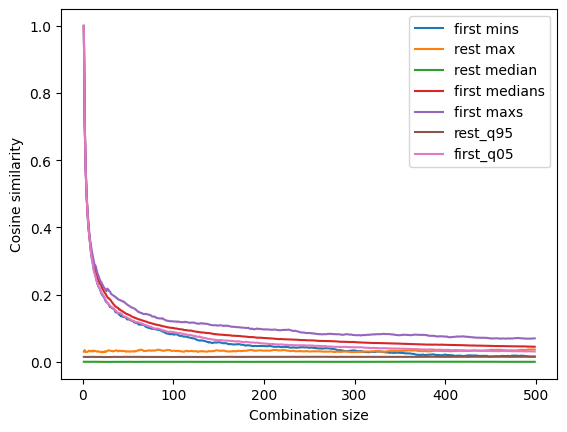

cross k 308
d 13100


100%|██████████| 499/499 [00:29<00:00, 16.88it/s]


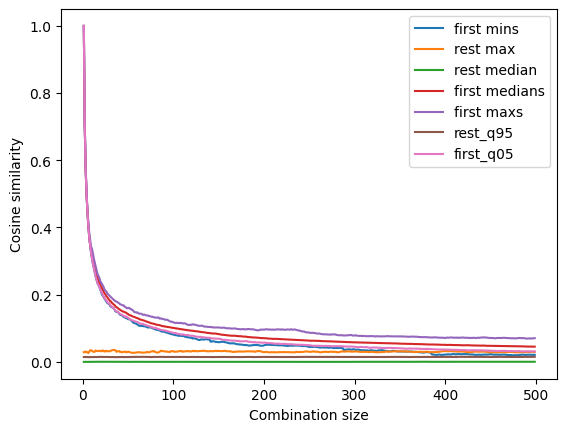

cross k 346
d 13600


100%|██████████| 499/499 [00:30<00:00, 16.26it/s]


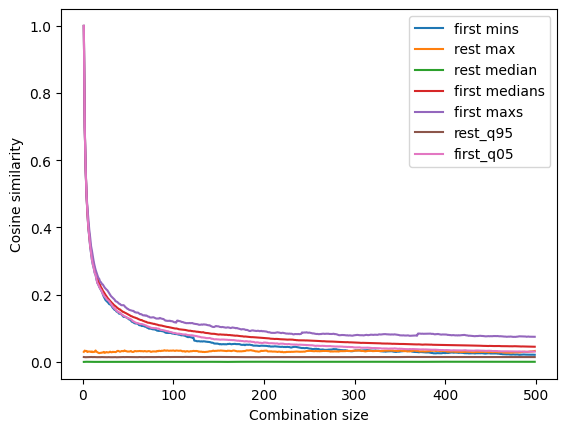

cross k 293
d 14100


100%|██████████| 499/499 [00:31<00:00, 15.69it/s]


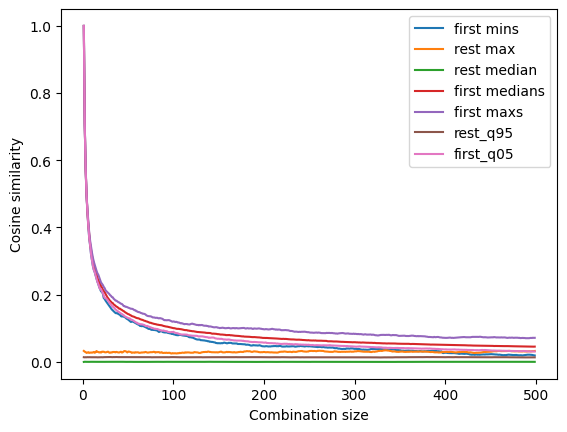

cross k 396
d 14600


100%|██████████| 499/499 [00:32<00:00, 15.34it/s]


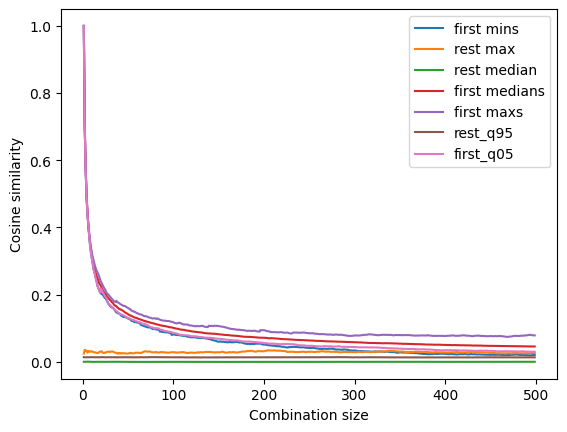

cross k 324
d 15100


100%|██████████| 499/499 [00:33<00:00, 14.76it/s]


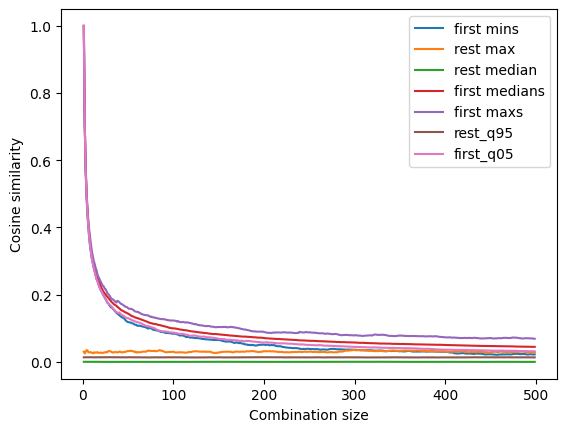

cross k 309
d 15600


100%|██████████| 499/499 [00:35<00:00, 14.21it/s]


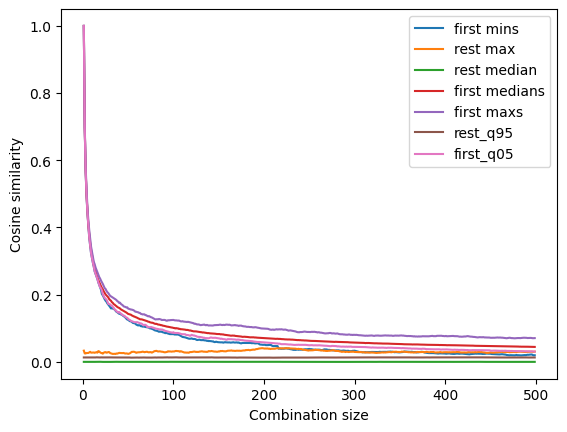

cross k 215


In [ ]:
n = 4000
cross_ks = []
dfs = []
for d in range(100,16000,500):
  print('d', d)
  k_max = 500
  df = get_df(n,d,k_max)
  dfs.append(df)
  crossings = np.argwhere(df['first_min'].to_numpy() < df['rest_max'].to_numpy())
  cross_k = k_max if len(crossings) == 0 else crossings.min()
  cross_ks.append(cross_k)
  plot_df(df)
  print('cross k', cross_k)

In [ ]:
cross_medians = []
for df in dfs:
  crossings = np.argwhere(df['first_median'].to_numpy() < df['rest_max'].to_numpy())
  cross_k = k_max if len(crossings) == 0 else crossings.min()
  cross_medians.append(cross_k)

In [ ]:
cross_ks_t = torch.tensor(cross_ks)

Text(0.5, 1.0, 'Phase shift for number of features ')

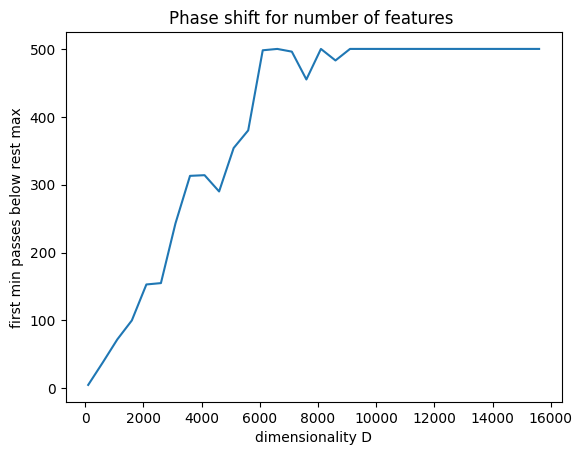

In [ ]:
ds = torch.arange(100,16000,500)
plt.plot(ds, cross_medians)
plt.xlabel('dimensionality D')
plt.ylabel('first min passes below rest max')
plt.title('Phase shift for number of features ')

Text(0.5, 1.0, 'Phase shift for number of features ')

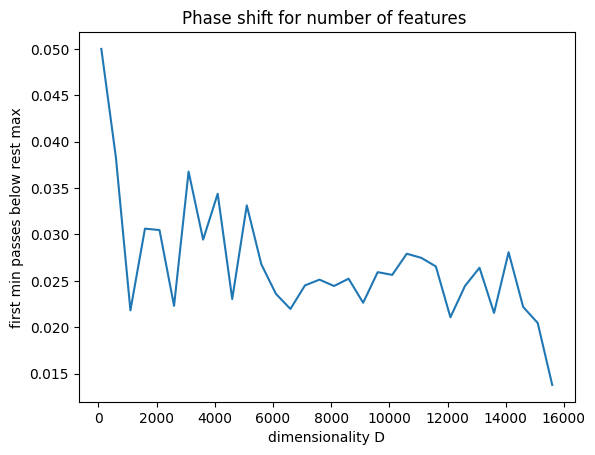

In [ ]:
ds = torch.arange(100,16000,500)
plt.plot(ds, cross_ks_t / ds)
plt.xlabel('dimensionality D')
plt.ylabel('first min passes below rest max')
plt.title('Phase shift for number of features ')

In [ ]:
cross_k

43

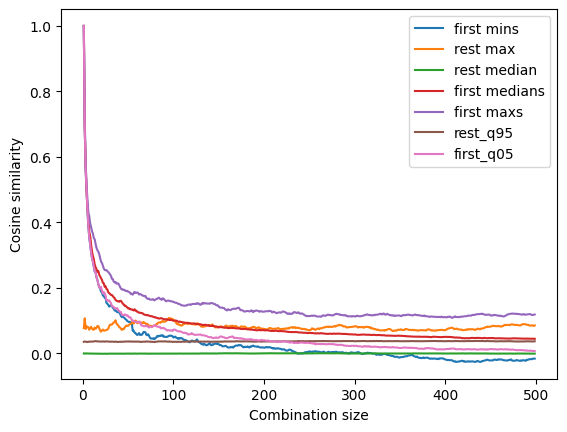

In [ ]:
df['first_min'].to_numpy()

array([0.99999982, 0.70304316, 0.58351022, 0.49569806, 0.44186845,
       0.37075403, 0.34178051, 0.31620374, 0.28802076, 0.27269059,
       0.26588461, 0.25434259, 0.24621205, 0.23832504, 0.22534253,
       0.20988899, 0.20156969, 0.18982476, 0.18144462, 0.17646317,
       0.17170189, 0.17072934, 0.1724471 , 0.16853397, 0.16496997,
       0.15741773, 0.15451892, 0.15047315, 0.14348929, 0.14147301,
       0.13997008, 0.13757841, 0.13633709, 0.13900483, 0.13400768,
       0.1316095 , 0.13183522, 0.13026232, 0.12944798, 0.12752149,
       0.12849267, 0.12935308, 0.1272659 , 0.12538549, 0.12480494,
       0.12156099, 0.12009485, 0.1182698 , 0.11368385, 0.1137769 ,
       0.11183572, 0.10909487, 0.10794858, 0.10739981, 0.10896709,
       0.10580254, 0.10486069, 0.10573635, 0.10338745, 0.10077751,
       0.09267139, 0.09291955, 0.09643173, 0.09594859, 0.0926491 ,
       0.09313108, 0.09286021, 0.09053454, 0.08875143, 0.08922204,
       0.08459852, 0.08674061, 0.08391643, 0.08330847, 0.08094

# Feature dimensionality


In [74]:
n = 6000
d = 1024
W = torch.randn(n, d)
Wnorm = F.normalize(W, dim=1)

In [75]:
def compute_feature_dimensionalities(W):
  Wnorm = F.normalize(W, dim=1)
  num = (W ** 2.).sum(dim=-1) #torch.pow(torch.norm(W, dim=-1),2)
  denom = torch.pow((Wnorm @ W.T), 2.).sum(dim=-1)
  feature_dimensionality = num / denom
  return feature_dimensionality

In [76]:
d / n

0.17066666666666666

tensor(874.8223)


(array([  1.,   0.,   2.,   2.,   1.,   4.,   6.,  11.,  16.,  16.,  29.,
         47.,  73.,  76., 107., 105., 155., 198., 201., 218., 251., 286.,
        321., 313., 331., 346., 327., 299., 331., 266., 268., 231., 231.,
        174., 152., 132., 105.,  75.,  69.,  58.,  40.,  28.,  31.,  14.,
         19.,  10.,  10.,   5.,   5.,   4.]),
 array([0.12438648, 0.12521635, 0.12604623, 0.12687609, 0.12770596,
        0.12853582, 0.1293657 , 0.13019556, 0.13102543, 0.13185529,
        0.13268517, 0.13351503, 0.13434491, 0.13517477, 0.13600464,
        0.1368345 , 0.13766438, 0.13849424, 0.13932411, 0.14015397,
        0.14098385, 0.14181371, 0.14264359, 0.14347345, 0.14430332,
        0.14513318, 0.14596306, 0.14679292, 0.14762279, 0.14845265,
        0.14928253, 0.15011239, 0.15094227, 0.15177213, 0.152602  ,
        0.15343186, 0.15426174, 0.1550916 , 0.15592147, 0.15675133,
        0.15758121, 0.15841107, 0.15924095, 0.16007081, 0.16090068,
        0.16173054, 0.16256042, 0.16339028, 0.

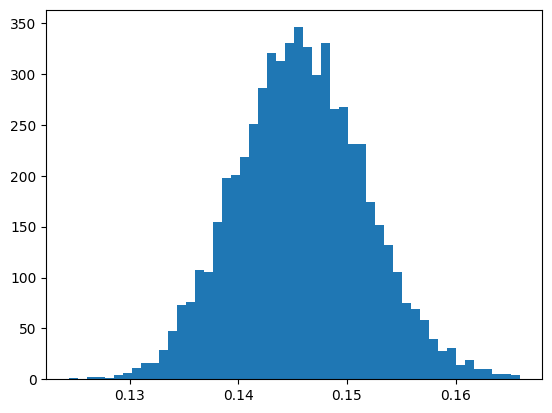

In [77]:
fd = compute_feature_dimensionalities(W)
print(fd.sum())
plt.hist(fd, bins=50)

tensor(511.6631)


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  3.,  1.,  5.,  7.,  8.,
        16., 15., 19., 20., 25., 26., 31., 37., 46., 48., 52., 48., 50.,
        43., 65., 51., 53., 45., 42., 50., 28., 34., 23., 33., 19., 22.,
        12.,  8.,  7.,  7.,  5.,  3.,  6.,  1.,  2.,  2.,  2.]),
 array([0.45894352, 0.46045092, 0.46195832, 0.46346572, 0.46497312,
        0.46648049, 0.4679879 , 0.4694953 , 0.4710027 , 0.4725101 ,
        0.4740175 , 0.4755249 , 0.4770323 , 0.47853971, 0.48004711,
        0.48155451, 0.48306188, 0.48456928, 0.48607668, 0.48758408,
        0.48909149, 0.49059889, 0.49210629, 0.49361369, 0.49512109,
        0.49662846, 0.49813586, 0.49964327, 0.50115067, 0.50265807,
        0.50416547, 0.50567287, 0.50718027, 0.50868767, 0.51019508,
        0.51170248, 0.51320988, 0.51471728, 0.51622468, 0.51773208,
        0.51923943, 0.52074683, 0.52225423, 0.52376163, 0.52526903,
        0.52677643, 0.52828383, 0.52979124, 0.53129864, 0.53280604,
        0.53431344]),
 <BarContainer

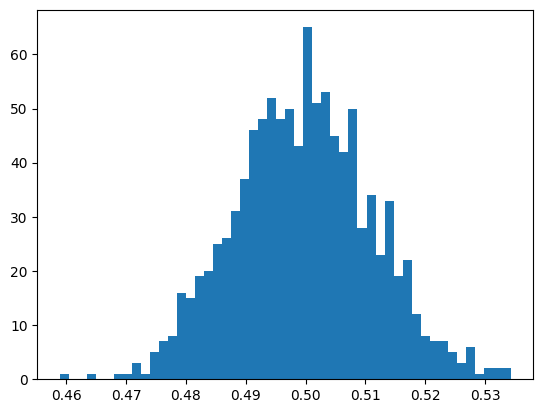

In [68]:
fd = compute_feature_dimensionalities(Wnorm)
print(fd.sum())
plt.hist(fd, bins=50)

In [40]:
fd.sum()

tensor(763.9606)

In [31]:
feature_dimensionality.sum()

tensor(1024.9965)

(array([  1.,   1.,   2.,   2.,  10.,   5.,  13.,   9.,  24.,  44.,  39.,
         53.,  68.,  70.,  89., 101., 108., 130., 156., 148., 157., 157.,
        162., 178., 161., 151., 150., 138., 115.,  87.,  96.,  79.,  67.,
         43.,  47.,  28.,  35.,  19.,  13.,  10.,  11.,   5.,   7.,   3.,
          2.,   1.,   3.,   0.,   1.,   1.]),
 array([0.28679612, 0.28921041, 0.29162472, 0.29403901, 0.29645333,
        0.29886761, 0.30128193, 0.30369622, 0.30611053, 0.30852482,
        0.31093913, 0.31335342, 0.31576774, 0.31818202, 0.32059634,
        0.32301062, 0.32542494, 0.32783923, 0.33025354, 0.33266783,
        0.33508214, 0.33749643, 0.33991075, 0.34232503, 0.34473935,
        0.34715363, 0.34956792, 0.35198224, 0.35439652, 0.35681084,
        0.35922512, 0.36163944, 0.36405373, 0.36646804, 0.36888233,
        0.37129664, 0.37371093, 0.37612525, 0.37853953, 0.38095385,
        0.38336813, 0.38578245, 0.38819674, 0.39061105, 0.39302534,
        0.39543965, 0.39785394, 0.40026826, 0.

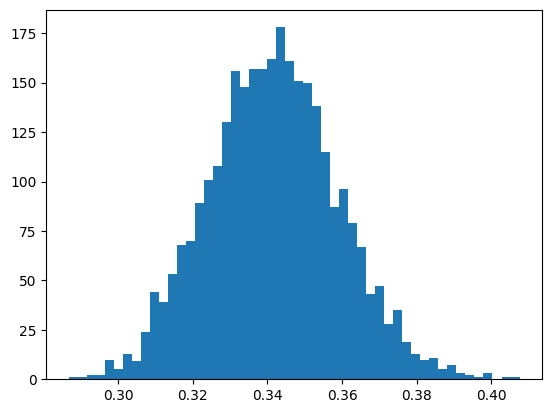

In [ ]:
len(crossings)

In [ ]:
cross_k

112

In [ ]:
s.shape

torch.Size([1024])

tensor([ 0.7245,  0.7135, -0.0459,  0.0246,  0.0053, -0.0572,  0.0042,  0.0248,
         0.0534,  0.0041])

## How many epsilon-orthogonal vectors can we squeeze in?

In [ ]:
d = 1000
g = 1010
ideal_sim = torch.eye(g).to(device)
criterion = torch.nn.MSELoss()
goal_eps = 0.01

In [ ]:
eps_basis = torch.nn.Parameter(torch.randn(g,d, device=device))

In [ ]:
optimizer = torch.optim.Adam([eps_basis], lr=0.03)

In [ ]:
for i in range(10000000):
  optimizer.zero_grad()
  eps_basis_norm = F.normalize(eps_basis,dim=1)
  sim = torch.einsum('ad,bd->ab',eps_basis_norm,eps_basis_norm)
  loss = criterion(sim, ideal_sim)
  actual_loss = torch.abs(sim - ideal_sim).max()
  if i % 100 == 0:
    print(i, loss.item(), actual_loss.item())
  if actual_loss < goal_eps:
    print('early stop', i, actual_loss)
    break
  loss.backward()
  optimizer.step()

0 0.0009973199339583516 0.16571101546287537
100 0.00017373332229908556 0.06079757586121559
200 5.986486576148309e-05 0.037526898086071014
300 2.488148311385885e-05 0.026248931884765625
400 1.3451630366034806e-05 0.020981144160032272
500 1.0346166163799353e-05 0.019027994945645332
600 9.923415746015962e-06 0.018125053495168686
700 9.915617738442961e-06 0.01771688088774681
800 9.914921974996105e-06 0.017390362918376923
900 9.914290785673074e-06 0.017083637416362762
1000 9.913694157148711e-06 0.01679222285747528
1100 9.913130270433612e-06 0.016514712944626808
1200 9.912597306538373e-06 0.0162503682076931
1300 9.912091627484187e-06 0.015998391434550285
1400 9.911614142765757e-06 0.015757916495203972
1500 9.911160304909572e-06 0.015528343617916107
1600 9.910729204420932e-06 0.015308989211916924
1700 9.91031811281573e-06 0.015099265612661839
1800 9.909928849083371e-06 0.014898569323122501
1900 9.909557775245048e-06 0.014706330373883247
2000 9.909203981806058e-06 0.014522268436849117
2100 9.9